In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
# import yt

from modules import *
from sim import *
from read_ramses import *


In [4]:
# choose simulation
sim_round = 3
sim_name = "alpha_eps0p1"
sim_dir = move_to_sim_dir(sim_round, sim_name)
sim_latex = sim_name_to_latex[sim_name]
print()

dump = get_dump(a_exp=0.14)
info = get_info(dump)

print("Dump: %d" % dump)
print("a_exp: %.3g" % info.a_exp)
print("Maximum AMR level: %d" % info.amr_level_max)


Moving to directory '/home/za9132/scratch/romain/round3/alpha_eps0p1'.

Dump: 43
a_exp: 0.103
Maximum AMR level: 13


In [5]:
from scipy.io import FortranFile

id_star_partfile = np.array([])
tau_starbirth_partfile = np.array([])

for i in range(1, info.ncpu+1):
    partfile = os.path.join("output_%.5d" % dump, "part_%.5d.out%.5d" % (dump, i))
    with FortranFile(partfile, 'r') as f:
        _, _, _ = f.read_ints('i'), f.read_ints('i'), f.read_ints('i')
        _, _, _, _, _ = f.read_reals('f8'), f.read_reals('f4'), f.read_reals('f8'), f.read_reals('f8'), f.read_reals('f4')
        _, _, _ = f.read_reals('f8'), f.read_reals('f8'), f.read_reals('f8') # position
        _, _, _ = f.read_reals('f8'), f.read_reals('f8'), f.read_reals('f8') # velocity
        _ = f.read_reals('f8') # mass
        id_part = f.read_ints('i') # id
        _ = f.read_ints('i') # level
        type_part = f.read_ints('b') # family
        _ = f.read_ints('b') # tag
        tau_partbirth = f.read_reals('f8') # birthtime
        _ = f.read_reals('f8') # metallicity

        id_star_partfile = np.concatenate((id_star_partfile, id_part[type_part==STAR]))
        tau_starbirth_partfile = np.concatenate((tau_starbirth_partfile, tau_partbirth[type_part==STAR]))
    

In [6]:
starbirth_cat = np.load("starbirth.npz")


In [7]:
id_star_cat = starbirth_cat["id"].astype(int)
tau_starbirth_cat = np.zeros_like(id_star_cat, dtype=float)
flag_unknowntime = np.zeros_like(id_star_cat, dtype=int)

for i, id_star in enumerate(id_star_cat):
        
    tau_starbirth = tau_starbirth_partfile[id_star_partfile == id_star]
    if len(tau_starbirth) > 0: 
        tau_starbirth_cat[i] = tau_starbirth[0]
    else:
        flag_unknowntime[i] = 1


In [435]:
integrand = lambda a: (info.Omega_m0 * a**(-1) + info.Omega_k0 + info.Omega_L0 * a**2)**(-1/2)
age_universe = quad(integrand, 0, 1)[0] / info.H0
time_starbirth_cat = tau_starbirth_cat / info.H0 + age_universe


Text(0.5, 1.0, '$\\varepsilon_{\\rm SF} = 1.0$ (sflogfiles + partfiles)')

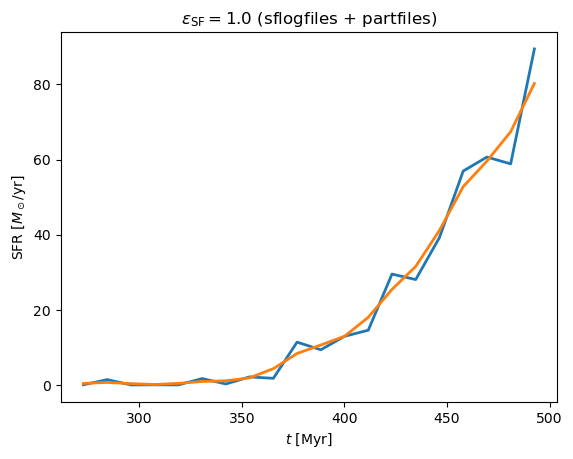

In [468]:
nbins = 20
filter_sigma = 10 * const.Myr

counts, bins = np.histogram(time_starbirth_cat[flag_unknowntime == 0], bins=nbins, weights=starbirth_cat["mass"][flag_unknowntime == 0])

star_birthtime_1d = bins[:-1] + np.diff(bins)[0]
star_mass_1d = counts
SFR_mass_1d = star_mass_1d / np.diff(bins)[0]

filter_sigma_idx = filter_sigma / np.diff(star_birthtime_1d)[0]
SFR_mass_1d_smoothed = gaussian_filter(SFR_mass_1d, sigma=filter_sigma_idx)

plt.plot(star_birthtime_1d / const.Myr, SFR_mass_1d / const.M_sol * const.yr, lw=2, alpha=1., label=sim_latex)
plt.plot(star_birthtime_1d / const.Myr, SFR_mass_1d_smoothed / const.M_sol * const.yr, lw=2, alpha=1., label=sim_latex)

plt.ylabel(r"SFR [$M_\odot / {\rm yr}$]")
plt.xlabel(r"$t$ [Myr]")

#plt.xlim(280, 570)
#plt.ylim(-10, 150)

plt.title(sim_latex + " (sflogfiles + partfiles)")

# plt.annotate(r'$|x|, |y|, |z| < 1~{\rm kpc}$', (290, 140))

# save_fig('SFR-logfile')

